In [1]:
#
### CONSTANTS
#

# Titanic dataset, from kaggle

DATA_TRAIN = './dataset/train.csv'
DATA_TEST = './dataset/test.csv'

In [2]:
#
### LIBRARIES
#

# Classic
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import sklearn.metrics

# PyTorch
import torch
import torch.nn as nn

# Pyro
import pyro
from pyro import distributions
from pyro.infer import SVI, Trace_ELBO, TracePredictive, EmpiricalMarginal
from pyro.infer.mcmc import MCMC, NUTS
from pyro.optim import Adam

# Custom
import preprocessing

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})  # Figure size

# Load Data

In [4]:
df_train = pd.read_csv(DATA_TRAIN, index_col='PassengerId')
df_test = pd.read_csv(DATA_TEST, index_col='PassengerId')

In [5]:
df_train.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Preprocessing

Lets create a function that does all the preprocessing, for training and validation datasets

## Missing values

In [6]:
# Missing values
df_train.isnull().sum()/len(df_train)*100.0

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

### Age

19,8 % of the samples do not have this value, lets see the distribution.

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


Mean: 29.69911764705882
Median: 28.0
Mode: 0    24.0
dtype: float64


[]

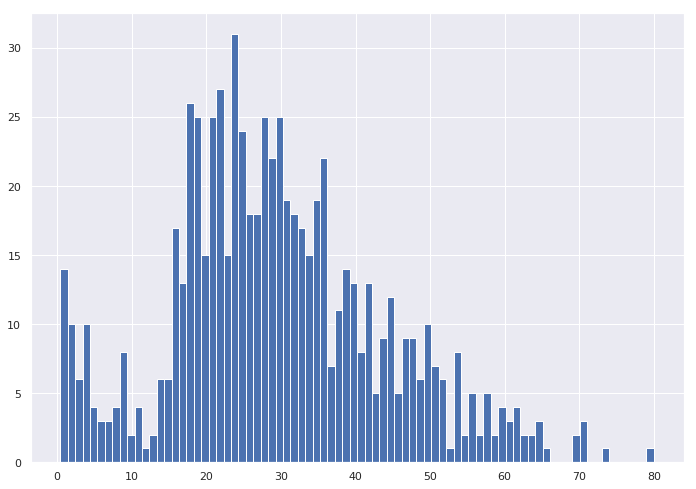

In [7]:
print(df_train['Age'].describe())
print("\n\nMean: {}\nMedian: {}\nMode: {}".format(
    df_train['Age'].mean(),
    df_train['Age'].median(),
    df_train['Age'].mode()
))
df_train['Age'].hist(bins=int(df_train['Age'].max())).plot()

### Cabin

77% of missing values is too much, discard the column.

### Embarked
0.25% of the values are missing, lets assing them to the most common value.

In [8]:
df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## Collinearities

### Parch+SibSp = Alone
This variable mixes 'SibSp' (siblings and spouses) and 'Parch' (parents and children) to determine wether an individual was travelling alone.

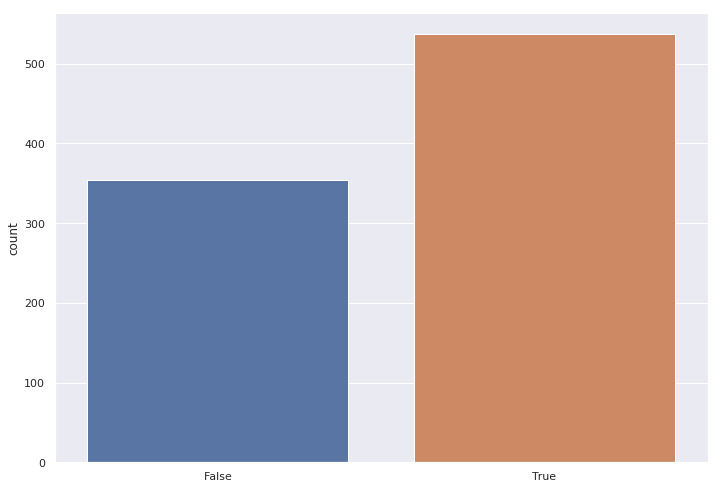

In [9]:
sns.countplot((df_train['Parch'] + df_train['SibSp'])<1)

### Pclass & Embarked

Perform *dummy encoding*, similiar *to one hot encoding* but with $n-1$ columns to avoid collinearities.


## Other
### Sex -> Male
Transform the sex variable to binary, 1 if male, else 0

### Unneeded columns
Discard the following columns:
* Name: some people do feature engineering to extract titles and do, not here.
* Ticket: same

## Proper transformation

In [10]:
prep = preprocessing.Preprocessing()
df_train_prep = prep.preprocess(df_train, train=True)

## Checks

In [11]:
df_train_prep.head()

,Survived,Age,Fare,Alone,Male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
1,0,22.0,7.2500,0,1,0,1,0,1
2,1,38.0,71.2833,0,0,0,0,0,0
3,1,26.0,7.9250,1,0,0,1,0,1
4,1,35.0,53.1000,0,0,0,0,0,1
5,0,35.0,8.0500,1,1,0,1,0,1


### Not nulls

In [12]:
df_train_prep.isnull().sum().sum()

0

### Low label correlations

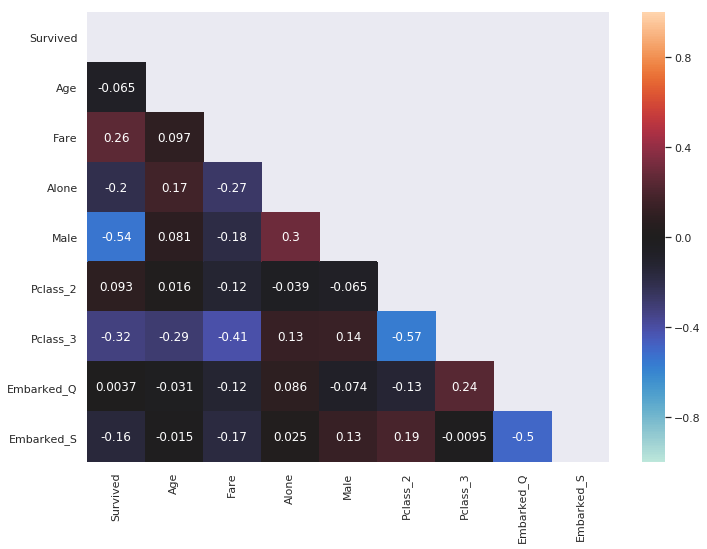

In [13]:
corr =  df_train_prep.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    corr,
    vmin=-1, 
    vmax=1,
    center=0, 
    annot=True,
    mask=mask
)

**NOTE 1:** compare the correlation matrix with `dummy encodings` against  the one with `one hot encodings`.

Pay attention to:
* Pclass_1 VS Pclass_3
* Embarked_C VS Embarked_S

![OHE correlations](img/corr_one_hot_encoding.png)

In fact we only need to know 2 columns in both cases to know the third.

**NOTE 2:** as 'Survived' is our target label, is good to have strong correlations.

# Prepare data
Get the train and test data ready to play.

In [14]:
# Training data (as matrix)
train_x = df_train_prep.drop(columns=['Survived'])
train_y = df_train_prep['Survived']

# Baseline (most common class)

In [15]:
df_train['Survived'].value_counts()/len(df_train)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

If the predictor states the most common class, we will get a $61.6\%$ of accuracy.

# Logistic regression

In [16]:
# Logistic Regression Model

class RegressionModel(nn.Module):
    def __init__(self, p):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(in_features=p, out_features=1, bias=True)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [17]:
# Regression parameters
regression_model = RegressionModel(train_x.shape[1])
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(regression_model.parameters(), lr=0.005)
num_iterations = 3000

In [18]:
# Train

x_data = torch.tensor(train_x.values, dtype=torch.float)
y_data = torch.tensor(train_y.values, dtype=torch.float)

def train():
    for j in range(num_iterations):
        y_pred = regression_model(x_data).squeeze(-1)
        loss = loss_fn(y_pred, y_data)
        optim.zero_grad()  # initialize gradients to zero
        loss.backward()
        optim.step()
        if (j + 1) % 200 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
    return y_pred

In [19]:
%%time 
y_pred = train()

[iteration 0200] loss: 154.0489
[iteration 0400] loss: 142.9861
[iteration 0600] loss: 137.6745
[iteration 0800] loss: 134.1325
[iteration 1000] loss: 131.4569
[iteration 1200] loss: 129.4251
[iteration 1400] loss: 127.9492
[iteration 1600] loss: 126.9227
[iteration 1800] loss: 126.2276
[iteration 2000] loss: 125.7633
[iteration 2200] loss: 125.4554
[iteration 2400] loss: 125.2524
[iteration 2600] loss: 125.1196
[iteration 2800] loss: 125.0334
[iteration 3000] loss: 124.9781
CPU times: user 2.72 s, sys: 32 ms, total: 2.75 s
Wall time: 946 ms


### Residual distribution

Should [residuals](https://en.wikipedia.org/wiki/Errors_and_residuals) should be normally distributed?. 

Avg :0.02651827223598957
Var: 0.13956405222415924


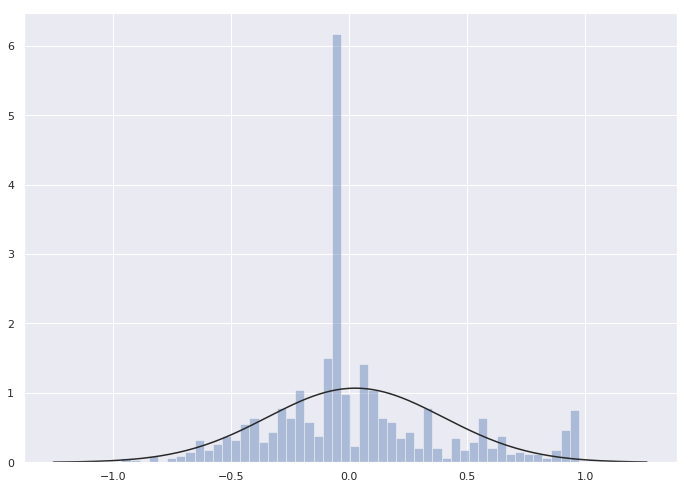

In [20]:
from scipy.stats import norm
residuals  = (y_data-y_pred).data.numpy()
print("Avg :{}\nVar: {}".format(residuals.mean(), residuals.var()))
sns.distplot(residuals, fit=stats.norm, kde=False, bins=50)

Lets perform a [Shapiro–Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) to test for normality.

In [21]:
_, pval = stats.shapiro(residuals)
print(pval)
if pval>0.05:
    print("OK")
else:
    print("Failed")

2.453091580875781e-18
Failed


In [22]:
# Just in case
stats.normaltest(residuals)

NormaltestResult(statistic=59.584175360746634, pvalue=1.1520218493566655e-13)

In a logistic regression, residuals are not normally distributed. See Bibliography [4.C](#Bibliography)

## Metrics

In [23]:
def print_metrics(true_labels, predictions):
    print("Accuracy: {}".format(
        sklearn.metrics.accuracy_score(true_labels,predictions)
    ))
    sns.heatmap(
        sklearn.metrics.confusion_matrix(true_labels,predictions)/len(true_labels),
        vmin=0.0,
        center=0.5,
        vmax=1.0,
        annot=True
    )
    plt.title("Confusion matrix (% data)")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

In [24]:
def  print_coeff_importance(coeffs, names):
    """Print the relative importance between regression coefficients
    """
    c_max = coeffs.max()
    c_min = coeffs.min()
    if c_max==c_min:
        scale = c_max
    else:
        scale = coeffs.max()-coeffs.min()        
    rel_coeffs =  list(zip( (coeffs-coeffs.mean())/scale, names))
    rel_coeffs.sort(reverse=True)
    for c,n in rel_coeffs:
        print("{:<15s}{}".format(n,c))

Accuracy: 0.8047138047138047


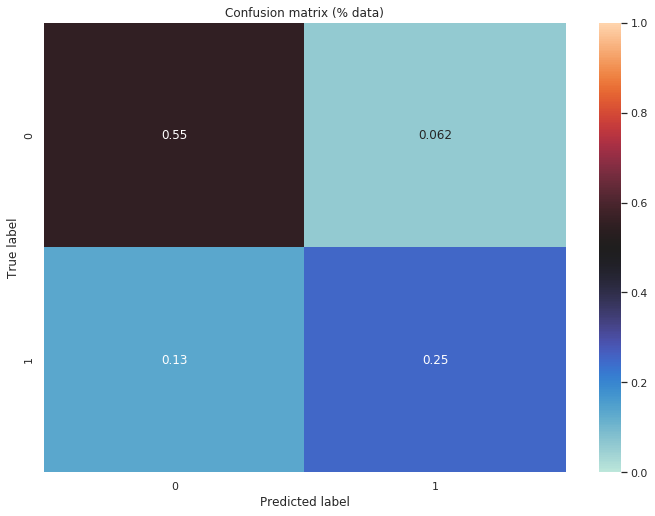

In [25]:
print_metrics(
    true_labels=y_data.data.numpy(),
    predictions=np.where(y_pred.data.numpy()>=0.5,1,0)
)

In [26]:
print_coeff_importance(
    regression_model.linear.weight.data.numpy()[0],
    train_x.columns
)

Embarked_Q     0.3934716284275055
Fare           0.24658718705177307
Alone          0.245184525847435
Age            0.23610979318618774
Embarked_S     0.09920477867126465
Pclass_2       -0.02755960449576378
Pclass_3       -0.586469829082489
Male           -0.6065284013748169


# Bayesian regression (SVI)

In [27]:
# Model

svi_reg_model = RegressionModel(train_x.shape[1])

def svi_model(x_data, y_data):
    # weight and bias priors
    p = x_data.shape[1]    
    w_prior = distributions.Normal(torch.zeros(1, p), torch.ones(1, p)).to_event(1)
    b_prior = distributions.Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])).to_event(1)  # Magic
    priors = {'linear.weight': w_prior, 'linear.bias': b_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", svi_reg_model, priors)
    # sample a nn (which also samples w and b)
    lifted_reg_model = lifted_module()
    scale = pyro.sample("sigma", distributions.Uniform(0., 10.))
    with pyro.plate("map", len(x_data)):
        # run the nn forward on data
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        # condition on the observed data
        pyro.sample(
            "obs",
            distributions.Normal(prediction_mean, scale),
            obs=y_data
        )
        return prediction_mean

In [28]:
# Guide

from pyro.contrib.autoguide import AutoDiagonalNormal
svi_guide = AutoDiagonalNormal(svi_model)

In [29]:
# Stochastic Variational Inference

optim = Adam({"lr": 0.03})
svi = SVI(svi_model, svi_guide, optim, loss=Trace_ELBO(), num_samples=1000)
num_iterations = 4000

def svi_train():
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_data, y_data)
        if j % 100 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data)))



In [30]:
%%time

svi_train()

[iteration 0001] loss: 2.7022
[iteration 0101] loss: 0.9493
[iteration 0201] loss: 1.2043
[iteration 0301] loss: 0.8651
[iteration 0401] loss: 0.8621
[iteration 0501] loss: 0.8504
[iteration 0601] loss: 0.8359
[iteration 0701] loss: 0.7670
[iteration 0801] loss: 0.6198
[iteration 0901] loss: 0.6083
[iteration 1001] loss: 0.6540
[iteration 1101] loss: 0.5386
[iteration 1201] loss: 0.5320
[iteration 1301] loss: 0.5035
[iteration 1401] loss: 0.5190
[iteration 1501] loss: 0.4978
[iteration 1601] loss: 0.4917
[iteration 1701] loss: 0.5150
[iteration 1801] loss: 0.5019
[iteration 1901] loss: 0.5007
[iteration 2001] loss: 0.5337
[iteration 2101] loss: 0.4930
[iteration 2201] loss: 0.4883
[iteration 2301] loss: 0.5214
[iteration 2401] loss: 0.5445
[iteration 2501] loss: 0.4993
[iteration 2601] loss: 0.5033
[iteration 2701] loss: 0.5183
[iteration 2801] loss: 0.5005
[iteration 2901] loss: 0.5082
[iteration 3001] loss: 0.4993
[iteration 3101] loss: 0.4977
[iteration 3201] loss: 0.4937
[iteration

In [31]:
def svi_wrapped_model(x_data, y_data):
    pyro.sample("prediction", distributions.Delta( svi_model(x_data, y_data)) )

svi_posterior = svi.run(x_data, y_data)

In [32]:
# posterior predictive distribution we can get samples from
svi_trace_pred = TracePredictive(
    svi_wrapped_model,
    svi_posterior,
    num_samples=1000
)

In [33]:
svi_post_pred = svi_trace_pred.run(x_data, None)

In [34]:
svi_get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def svi_summary(traces, sites):
    marginal = svi_get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        site_stats[site_name] = marginal_site.apply(
            lambda x: pd.Series.describe(x, percentiles=[.05, 0.25, 0.5, 0.75, 0.95]),
            axis=1
        ) [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [35]:
svi_post_summary = svi_summary(svi_post_pred, sites=['prediction', 'obs'])
svi_mu = svi_post_summary["prediction"]
svi_y = svi_post_summary["obs"]
svi_predictions = pd.DataFrame({
    "mu_mean": svi_mu["mean"],
    "mu_perc_5": svi_mu["5%"],
    "mu_perc_95": svi_mu["95%"],
    "y_mean": svi_y["mean"],
    "y_perc_5": svi_y["5%"],
    "y_perc_95": svi_y["95%"],
    "true_y": y_data,
})

In [36]:
svi_predictions.head()

,mu_mean,mu_perc_5,mu_perc_95,true_y,y_mean,y_perc_5,y_perc_95
0,0.052268,0.034454,0.075074,0.0,0.067887,-0.534834,0.665348
1,0.917873,0.895595,0.937833,1.0,0.926537,0.308756,1.555276
2,0.455524,0.346132,0.566067,1.0,0.444540,-0.147287,1.146659
3,0.882681,0.842993,0.916983,1.0,0.869988,0.246331,1.504278
4,0.034011,0.020580,0.053415,0.0,0.022846,-0.560122,0.612636


## Metrics

Accuracy: 0.8103254769921436


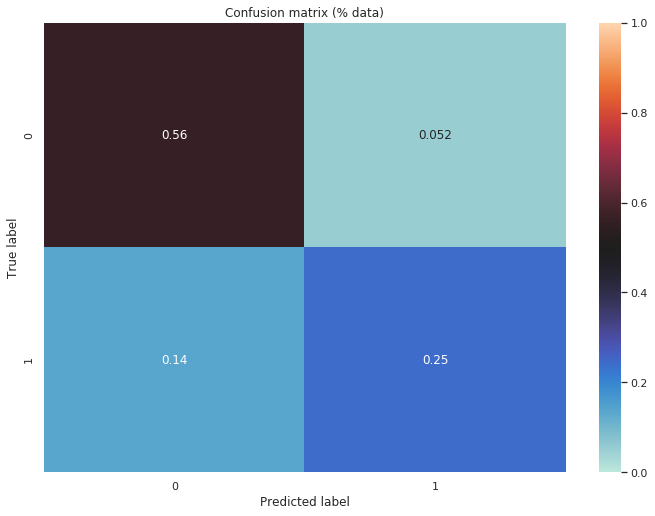

In [37]:
print_metrics(
    true_labels=svi_predictions['true_y'],
    predictions=np.where(svi_predictions['y_mean']>=0.5,1,0)
)

In [38]:
# Lets see the confidence in the params
list(zip( train_x.columns, zip(*pyro.get_param_store().values()) ))

[('Age',
  (tensor(-0.0343, grad_fn=<SelectBackward>),
   tensor(0.0025, grad_fn=<SelectBackward>))),
 ('Fare',
  (tensor(-0.0040, grad_fn=<SelectBackward>),
   tensor(0.0015, grad_fn=<SelectBackward>))),
 ('Alone',
  (tensor(-0.0201, grad_fn=<SelectBackward>),
   tensor(0.1457, grad_fn=<SelectBackward>))),
 ('Male',
  (tensor(-2.8982, grad_fn=<SelectBackward>),
   tensor(0.1094, grad_fn=<SelectBackward>))),
 ('Pclass_2',
  (tensor(-0.8176, grad_fn=<SelectBackward>),
   tensor(0.1668, grad_fn=<SelectBackward>))),
 ('Pclass_3',
  (tensor(-2.7010, grad_fn=<SelectBackward>),
   tensor(0.1336, grad_fn=<SelectBackward>))),
 ('Embarked_Q',
  (tensor(0.3762, grad_fn=<SelectBackward>),
   tensor(0.2017, grad_fn=<SelectBackward>))),
 ('Embarked_S',
  (tensor(-0.5650, grad_fn=<SelectBackward>),
   tensor(0.1543, grad_fn=<SelectBackward>)))]

In [39]:
print_coeff_importance(
    list(pyro.get_param_store().values())[0].data.numpy(),
    train_x.columns
)

Embarked_Q     0.13298329710960388
Fare           0.08062943071126938
Alone          0.07841573655605316
Age            0.07646910101175308
Embarked_S     0.00339952833019197
Pclass_2       -0.03137413412332535
Pclass_3       -0.290669322013855
Male           -0.3178234398365021


# Bayesian Regression (MCMC - NUTS)

In [40]:
def mcmc_model(x_data, y_data):
    p = x_data.shape[1]
    weights = pyro.sample('mcmc_weights', distributions.Normal(torch.zeros(p), torch.ones(p)))
    bias = pyro.sample('mcmc_bias', distributions.Normal(torch.zeros(1), torch.ones(1)))
    y_pred = pyro.sample(
        'mcmc_y',
        distributions.Bernoulli( (torch.sigmoid((weights*x_data)+bias).sum(-1)) ),
        obs=y_data
    )
    return y_pred

In [41]:
%%time

nuts_kernel = NUTS(mcmc_model, adapt_step_size=True)
mcmc_train = MCMC(nuts_kernel, num_samples=1000, warmup_steps=300).run(x_data, y_data)

Sample: 100%|██████████| 1300/1300 [01:04<00:00, 20.09it/s, step size=2.71e-01, acc. rate=0.965]

CPU times: user 2min 40s, sys: 1.24 s, total: 2min 41s
Wall time: 1min 4s


In [42]:
mcmc_weights = EmpiricalMarginal(mcmc_train, 'mcmc_weights')
mcmc_bias = EmpiricalMarginal(mcmc_train, 'mcmc_bias')
mcmc_y = EmpiricalMarginal(mcmc_train, 'mcmc_y')

Accuracy: 0.7519640852974186


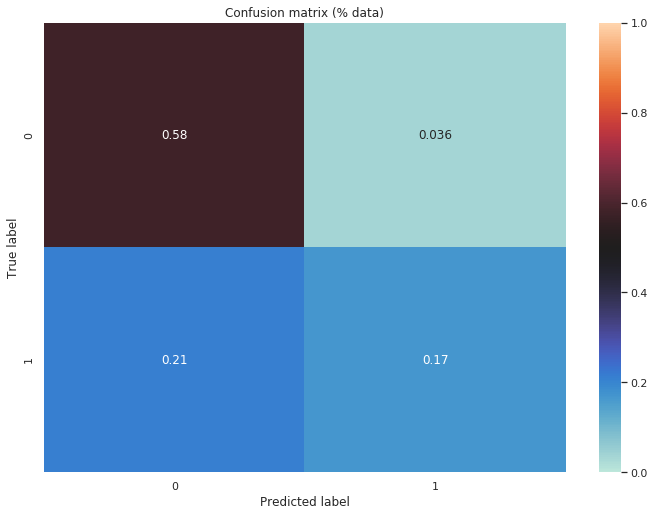

In [43]:
print_metrics(
    true_labels=y_data.data.numpy(),
    predictions= np.where(
        torch.sigmoid(
            (mcmc_weights.mean*x_data)+mcmc_bias.mean
        ).sum(-1).data.numpy() >= 0.5,
        1,
        0
    )
)

In [44]:
print_coeff_importance(mcmc_weights.mean.data.numpy(), train_x.columns)

Pclass_2       0.5104401707649231
Age            0.34454137086868286
Embarked_Q     0.32189619541168213
Fare           0.17225559055805206
Alone          -0.24360378086566925
Embarked_S     -0.2539411187171936
Pclass_3       -0.3620283305644989
Male           -0.4895598590373993


# Comparison


## Metrics

| Model| Accuracy | Training time|
| ------------------- |:-------------------:|:------------:|
| Logistic Regression |        80.47%       |  00:00:01    |
| Bayesian SVI        |        81.03%       |  00:00:17    |
| Bayesian NUTS       |        75,20%       |  00:01:04    |


## Coefficients


### Logistic Regression
```
Embarked_Q     0.3934716284275055
Fare           0.24658718705177307
Alone          0.245184525847435
Age            0.23610979318618774
Embarked_S     0.09920477867126465
Pclass_2       -0.02755960449576378
Pclass_3       -0.586469829082489
Male           -0.6065284013748169
```


### Bayesian SVI
```
Embarked_Q     0.13298329710960388
Fare           0.08062943071126938
Alone          0.07841573655605316
Age            0.07646910101175308
Embarked_S     0.00339952833019197
Pclass_2       -0.03137413412332535
Pclass_3       -0.290669322013855
Male           -0.3178234398365021
```

### Bayesian NUTS
```
Pclass_2       0.5104401707649231
Age            0.34454137086868286
Embarked_Q     0.32189619541168213
Fare           0.17225559055805206
Alone          -0.24360378086566925
Embarked_S     -0.2539411187171936
Pclass_3       -0.3620283305644989
Male           -0.4895598590373993
```

The ranking on coefficients is the same in the logistic regression and the Bayesian SVI. Although the bayesian NUTS share some similarities.

The Titanic wasn't a good place for 3rd class male travellers. Sorry, Di Caprio.

## Bibliography
1. [Bayesian Regression - Introduction (Part 1)](http://pyro.ai/examples/bayesian_regression.html)
* [Understanding Pyro’s Model and Guide: A Love Story](https://medium.com/paper-club/understanding-pyros-model-and-guide-a-love-story-7f3aa0603886)
* [Question about separating model and guide function](https://forum.pyro.ai/t/question-about-separating-model-and-guide-function/86)
* Papers
  1. [Variational Inference: A Review for Statisticians](https://arxiv.org/pdf/1601.00670.pdf)
  * [Markov Chain Monte Carlo and Variational Inference:Bridging the Gap](http://proceedings.mlr.press/v37/salimans15.pdf)
  * [Logistic Regression Diagnostics](https://projecteuclid.org/download/pdf_1/euclid.aos/1176345513)
  * [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo](https://arxiv.org/abs/1111.4246)
  